In [24]:
import json
from urllib.request import urlopen
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from itertools import islice
from sklearn import preprocessing
import spacy
from spacy import displacy
import sklearn.metrics
import plotly.express as px
import pickle
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
!python3 -m spacy download en_core_web_sm

In [26]:
TRAIN_DATA = "https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/Rhetorical_Role_Benchmark/Data/train.json"
train_json = json.loads(urlopen(TRAIN_DATA).read())
VAL_DATA = "https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/Rhetorical_Role_Benchmark/Data/dev.json"
val_json = json.loads(urlopen(VAL_DATA).read())

In [27]:
def preprocess_json(t_json):
    docs = []
    for rec in t_json:
        doc = []
        for line in rec['annotations'][0]['result']:
            doc.append({'text': line['value']['text'], 'label': line['value']['labels'][0] 
            if len(line['value']['labels'])>0 else 'NONE'})
        docs.append(doc)
    docs_df = pd.json_normalize([item for sublist in docs for item in sublist])

    le = preprocessing.LabelEncoder()
    le.fit(docs_df.label)
    sd = le.transform(docs_df.label)
    docs_df.label = sd
    return docs_df, docs
# print(docs[9][0])
t_docs_df, t_docs = preprocess_json(train_json)
v_docs_df, v_docs = preprocess_json(val_json)

In [46]:
len(t_docs), len(v_docs)

(247, 30)

In [48]:
len(t_docs_df), len(v_docs_df)

(28986, 2879)

In [28]:
ndocs = t_docs
label_text_map = {}
for i in range(len(ndocs)):
    for j in range(len(ndocs[i])):
        l, t = ndocs[i][j]['label'], ndocs[i][j]['text']
        if l in label_text_map:
            label_text_map[l].append(t)
        else:
            label_text_map[l] = [t]


In [29]:
text_l, label_l = [], []
for k,v in label_text_map.items():
    text_l.append(' '.join(v))
    label_l.append(k)
assert(len(text_l) == len(label_l))

In [271]:
df = pd.DataFrame({'text': text_l,'label': label_l}, columns = ['text', 'label'])

In [272]:
for tok in nlp(df.iloc[2]['text']):
    print(tok.lemma_, tok.is_stop, tok.text)

2 False 2
. False .
the True The
accuse False accused
be True is
in True in
appeal False appeal
in True in
the True the
following False following
circumstances:- False circumstances:-
the True The
appellant False appellant
be True was
accuse False accused
of True of
offence False offences
punishable False punishable
under True under
Sections False Sections
498A False 498A
and True and
306 False 306
of True of
the True the
Indian False Indian
Penal False Penal
Code False Code
, False ,
1860 False 1860
( False (
Hereinafter False Hereinafter
refer False referred
to True to
as True as
the True the
` False `
IPC False IPC
' False '
, False ,
for True for
brevity False brevity
) False )
. False .
the True The
complainant False complainant
Sonabai False Sonabai
be True was
a True a
resident False resident
of True of
Hanumantwadi False Hanumantwadi
in True in
Basavakalyan False Basavakalyan
Taluk False Taluk
, False ,
Bidar False Bidar
District False District
. False .
she True She
have True 

In [451]:
nlp = spacy.load('en_core_web_sm')
df['lemmatized']=df['text'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) 
            if (token.is_stop==False and token.is_digit==False and token.is_punct==False)]))


In [274]:
df['lemmatized'] = df['lemmatized'].apply(lambda x: x.strip().replace('\n', ''))

In [275]:
df['text']

0           IN THE HIGH COURT OF KARNATAKA,\n       ...
1     \n       Heard the learned Counsel for the app...
2     2. The accused is in appeal in the following c...
3     It is claimed that the accused had looked afte...
4     On conclusion of the trial and on examination ...
5     \n 4. learned Counsel for the appellant would ...
6     \n 6. Given the rival contentions, as pointed ...
7     \n The apex court, in the decision cited by th...
8     In that view of the matter, it cannot be concl...
9     \n In the result, the appeal is allowed. The j...
10    The proposed substantial questions of law fram...
11    Under s. 21 of the Act, the High Court exercis...
12    \nThe next decision is Gunda Subbayya v. Commi...
Name: text, dtype: object

In [276]:
df['lemmatized'].apply(lambda f: len(f.split()))

0     3109
1      385
2     3648
3      457
4      679
5      587
6     7223
7     1422
8      484
9      601
10     428
11     694
12       8
Name: lemmatized, dtype: int64

In [112]:
# cv=CountVectorizer(analyzer='word')
cv=CountVectorizer(ngram_range=(2,2))
data=cv.fit_transform(df['lemmatized'])
df_dtm_bigram = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm_bigram.index=df.index
df_dtm_bigram.head(3)


/Users/preethamthava/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00 000,00 complainant,000 allow,000 although,000 assessee,000 company,000 count,000 default,000 give,000 offence,...,years occ,years total,yelahanka new,yellow check,york america,york buy,york sum,young brother,young child,zaveri appellant
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [116]:
def take(n, iterable):
    return list(islice(iterable, n))

def topN(row, n):
    x = row.to_dict() # convert the input row to a dictionary 
    x = {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)} # sort the dictionary based on their values 
    n_items = take(n, x.items()) # extract the first n values from the dictionary 
    return n_items

n = 5 #number of elements needed
df['top_5_words'] = df_dtm.apply(lambda row : topN(row,n), axis = 1) 

In [115]:
df['top_5_words_bigram'].values

array([list([('age year', 37), ('income tax', 22), ('bank ltd', 16), ('eastern bank', 15), ('high court', 15)]),
       list([('sd judge', 5), ('appellate jurisdiction', 4), ('certify copy', 4), ('certificate ex', 3), ('criminal appeal', 3)]),
       list([('accuse no', 23), ('defendant no', 21), ('assessee company', 19), ('high court', 15), ('income tax', 14)]),
       list([('ill treatment', 6), ('high court', 5), ('commit suicide', 4), ('ill treat', 3), ('learn counsel', 3)]),
       list([('section ipc', 11), ('pay fine', 8), ('imprisonment month', 7), ('undergo imprisonment', 7), ('000 default', 6)]),
       list([('vs state', 6), ('death sentence', 5), ('assessee company', 4), ('bank ltd', 4), ('eastern bank', 4)]),
       list([('accuse no', 57), ('high court', 32), ('suit schedule', 23), ('bank ltd', 21), ('eastern bank', 21)]),
       list([('income tax', 23), ('apex court', 12), ('commissioner income', 10), ('commit suicide', 8), ('death sentence', 6)]),
       list([('penden

In [118]:
df['top_5_words'].values

array([list([('year', 48), ('age', 38), ('profit', 38), ('company', 36), ('act', 34)]),
       list([('ex', 23), ('copy', 9), ('judge', 8), ('judgment', 8), ('court', 7)]),
       list([('no', 88), ('accuse', 50), ('section', 44), ('assessee', 41), ('company', 33)]),
       list([('ill', 11), ('case', 9), ('court', 9), ('accuse', 8), ('complainant', 6)]),
       list([('section', 17), ('fine', 14), ('imprisonment', 14), ('ipc', 11), ('ltd', 11)]),
       list([('case', 11), ('madras', 9), ('appellant', 8), ('evidence', 8), ('point', 8)]),
       list([('no', 117), ('accuse', 105), ('act', 88), ('case', 73), ('evidence', 70)]),
       list([('court', 32), ('case', 31), ('tax', 28), ('income', 27), ('profit', 23)]),
       list([('property', 14), ('court', 11), ('no', 11), ('suit', 11), ('possession', 10)]),
       list([('shall', 19), ('court', 14), ('appeal', 12), ('no', 12), ('order', 12)]),
       list([('case', 10), ('section', 9), ('order', 7), ('plaintiff', 7), ('schedule', 7)]),


In [124]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(docs_df.label)
sd = le.transform(docs_df.label)
docs_df.label = sd

In [125]:
docs_df

,text,label
0,"IN THE HIGH COURT OF KARNATAKA,\n ...",6
1,\n\n BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...,6
2,This Criminal Appeal is filed under Section 37...,6
3,\n\n This appeal coming on for hearing t...,6
4,\n Heard the learned Counsel for the app...,5
...,...,...
1426,"However, as earlier indicated, in case the acc...",0
1427,No such argument having been advanced before u...,9
1428,"With these observations, the appeal is dismissed.",11
1429,\n T.N.A.,5


EDA

In [420]:
len(t_docs)

247

In [421]:
eda_docs = t_docs
full_text_docs = [' '.join(k['text'].strip() for k in d) for d in eda_docs]

In [422]:
full_text_df = pd.DataFrame(full_text_docs)

In [467]:
list(text_length).index(5635)

190

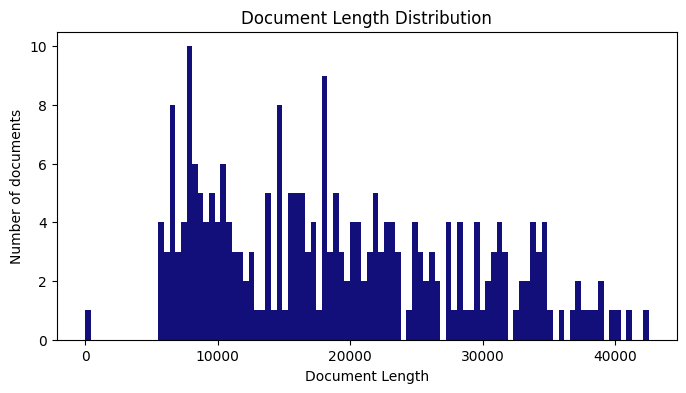

In [460]:
text_length = full_text_df[0].drop_duplicates().apply(len)

fig = plt.figure(figsize=(8,4))

ax1 = text_length.plot(kind='hist', color = "#120f7a", bins=100)
ax1.set_title('Document Length Distribution')
ax1.set_ylabel("Number of documents")
ax1.set_xlabel("Document Length")

plt.show()

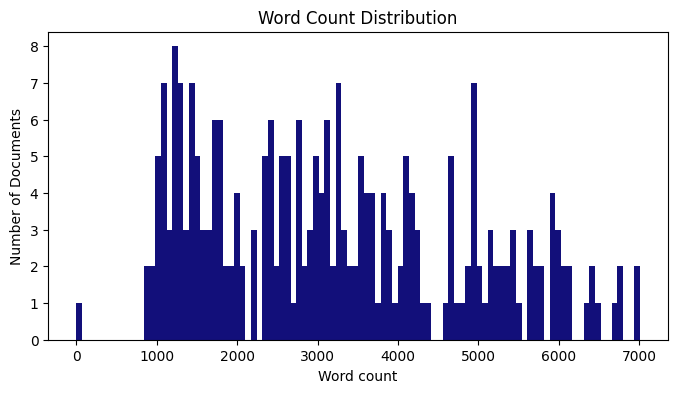

In [461]:
word_count = full_text_df[0].drop_duplicates().apply(lambda x: len(str(x).split()))

fig = plt.figure(figsize=(8,4))

ax1 = word_count.plot(kind='hist', color = "#120f7a", bins=100)
ax1.set_title('Word Count Distribution')
ax1.set_ylabel("Number of Documents")
ax1.set_xlabel("Word count")

plt.show()

In [264]:
def get_top_n_words(corpus, n=None, remove_stop_words=False, n_words=1): # if n_words=1 -> unigrams, if n_words=2 -> bigrams..
    if remove_stop_words:
        vec = CountVectorizer(stop_words = 'english', ngram_range=(n_words, n_words)).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(n_words, n_words)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [426]:
common_words = get_top_n_words(full_text_df[0].drop_duplicates(), 10, remove_stop_words=True, n_words=2)
for word, freq in common_words:
    print(word, freq)

high court 1626
income tax 1298
trial court 532
learned counsel 497
tax act 399
accused persons 381
order dated 378
commissioner income 373
sub section 351
penal code 321


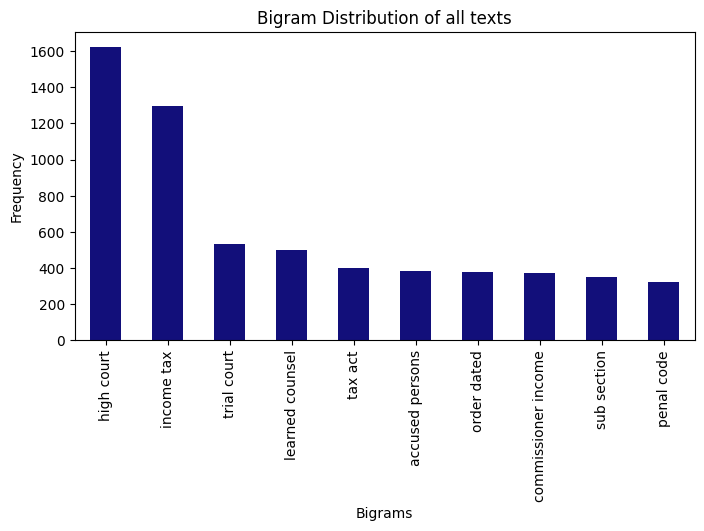

In [427]:
df_tmp = pd.DataFrame(common_words, columns = ['text' , 'count'])

fig = plt.figure(figsize=(8,4))

ax1 = df_tmp.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title('Bigram Distribution of all texts')
ax1.set_xlabel("Bigrams")
ax1.set_ylabel("Frequency")

plt.show()

In [428]:
label_text_map.keys()

dict_keys(['PREAMBLE', 'NONE', 'FAC', 'ARG_RESPONDENT', 'RLC', 'ARG_PETITIONER', 'ANALYSIS', 'PRE_RELIED', 'RATIO', 'RPC', 'ISSUE', 'STA', 'PRE_NOT_RELIED'])

In [429]:
common_words = get_top_n_words(label_text_map['ANALYSIS'], 10, remove_stop_words=True, n_words=3)
for word, freq in common_words:
    print(word, freq)

suit schedule property 18
indian penal code 14
income tax act 13
sub 10 act 12
indian income tax 11
indian evidence act 9
possession suit schedule 9
23 indian income 8
eastern bank madras 8
learned sessions judge 7


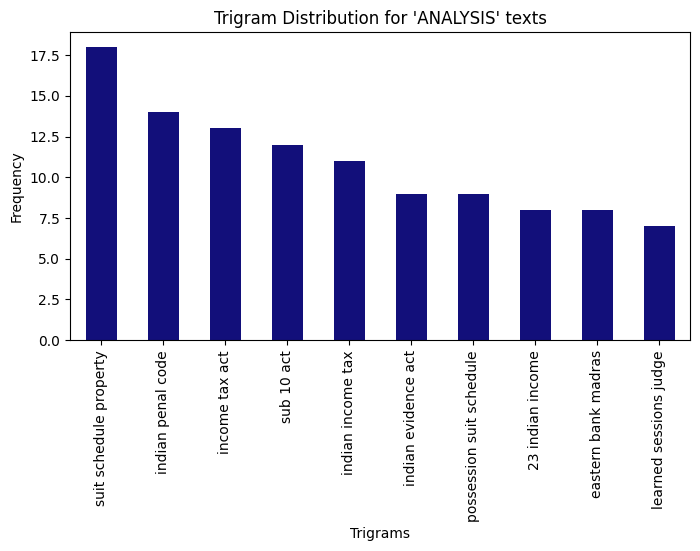

In [430]:
df_tmp = pd.DataFrame(common_words, columns = ['text' , 'count'])

fig = plt.figure(figsize=(8,4))

ax1 = df_tmp.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title("Trigram Distribution for 'ANALYSIS' texts")
ax1.set_xlabel("Trigrams")
ax1.set_ylabel("Frequency")

plt.show()

In [431]:
common_words = get_top_n_words(label_text_map['PRE_RELIED'], 10, remove_stop_words=True, n_words=3)
for word, freq in common_words:
    print(word, freq)

commissioner income tax 10
apex court held 5
income tax act 4
supra apex court 4
income tax officer 4
income tax bombay 4
dhakeswari cotton mills 3
delivering judgment behalf 3
singh vs state 2
bench apex court 2


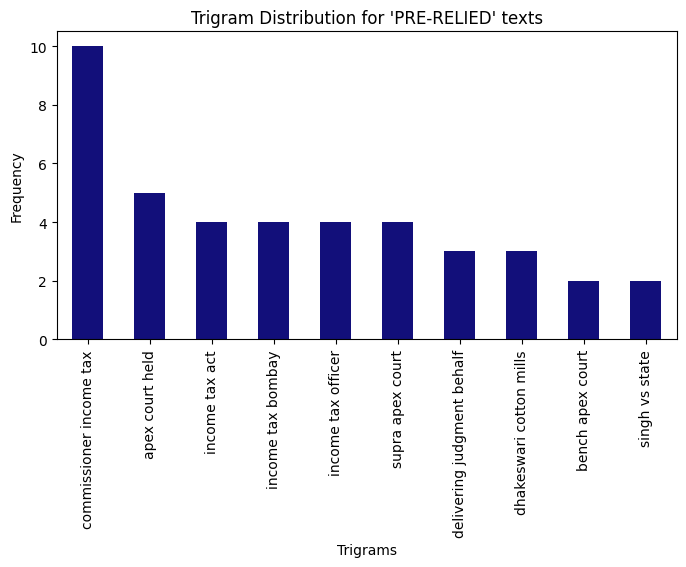

In [432]:
df_tmp = pd.DataFrame(common_words, columns = ['text' , 'count'])

fig = plt.figure(figsize=(8,4))

ax1 = df_tmp.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "#120f7a")
ax1.set_title("Trigram Distribution for 'PRE-RELIED' texts")
ax1.set_xlabel("Trigrams")
ax1.set_ylabel("Frequency")

plt.show()

In [325]:
all_texts, all_labels = [], []
for k,v in label_text_map.items():
    all_texts+=v
    all_labels+=([k]*len(v))


In [327]:
len(all_texts)

1431

In [330]:
label_text_df = pd.DataFrame(list(zip(all_texts, all_labels)), columns=['text', 'label'])

In [331]:
label_text_df

,text,label
0,"IN THE HIGH COURT OF KARNATAKA,\n ...",PREAMBLE
1,\n\n BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...,PREAMBLE
2,This Criminal Appeal is filed under Section 37...,PREAMBLE
3,\n\n This appeal coming on for hearing t...,PREAMBLE
4,"1/11\n\nIN THE HIGH COURT OF KARNATAKA, BENGAL...",PREAMBLE
...,...,...
1426,\n Explanation.-For the purpose of this sectio...,STA
1427,"In our opinion, this would clearly deny to the...",STA
1428,--(1) No person shall be convicted of any offe...,STA
1429,""" In our opinion ,. the protection given by Ar...",STA


In [367]:
fig = px.bar(x = np.unique(label_text_df['label']),
y = [list(label_text_df['label']).count(i) for i in np.unique(label_text_df['label'])] , 
            color = np.unique(label_text_df['label']),
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Labels")
fig.update_yaxes(title = "Number of Texts")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Label Type Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        template="plotly_white")
fig.show()


In [349]:
label_text_df["len_str"] = label_text_df["text"].apply(len)
fig = px.histogram(data_frame = label_text_df, x = "len_str", marginal="violin", nbins = 400 )
fig.layout.xaxis.title.text = 'Length of texts'
fig.layout.yaxis.title.text = 'Frequency'
fig.update_layout(template="plotly_white")
fig.show()

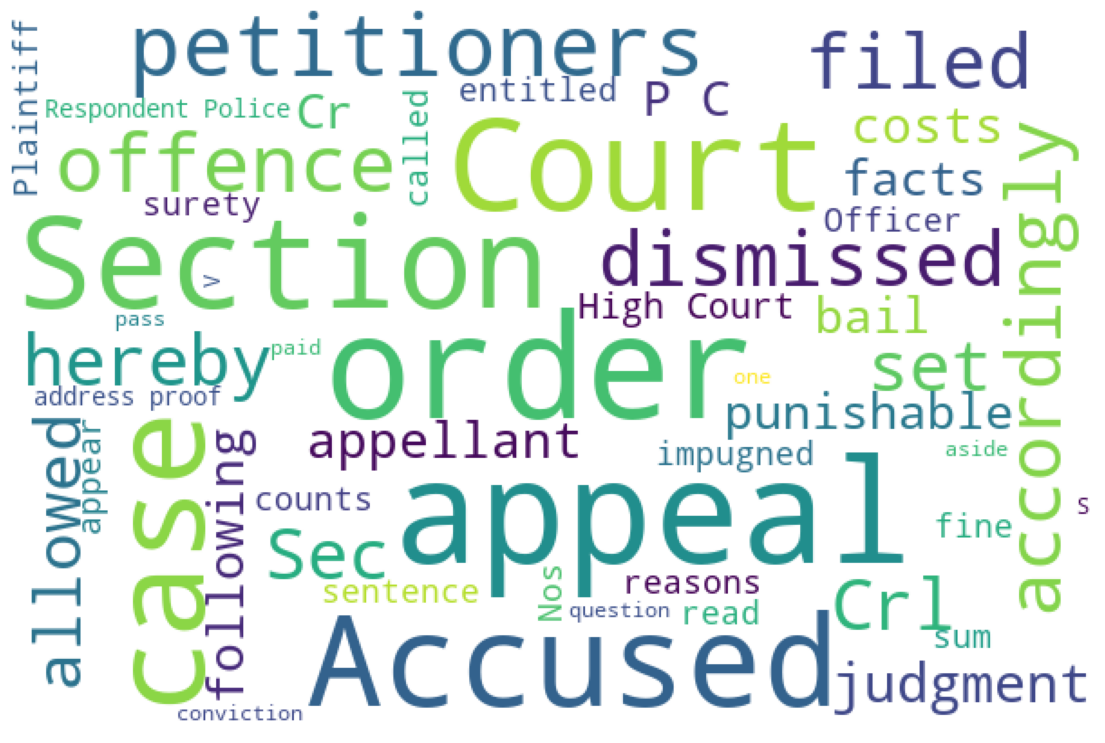

In [366]:
wordclouds = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=80, max_words=50,
                      width = 600, height = 400,
                      background_color='white').generate(df.iloc[9]['text'])
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordclouds, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordclouds)

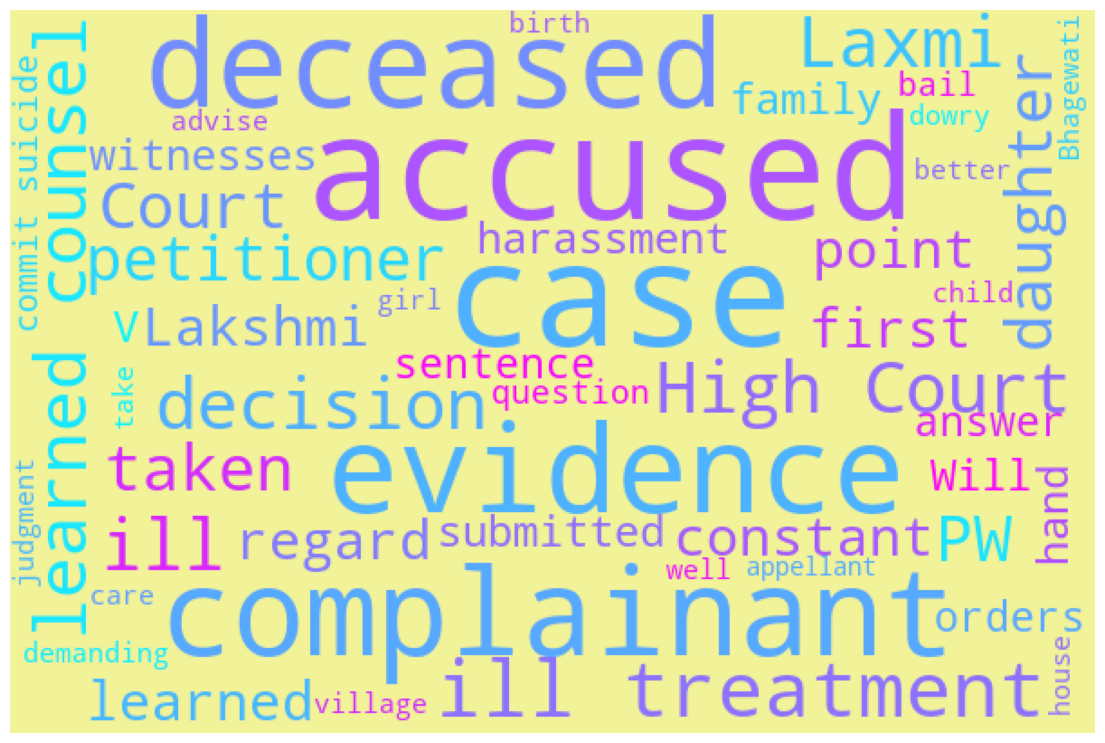

In [409]:
wordclouds2 = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=80, max_words=50,
                      width = 600, height = 400, colormap='cool',
                      background_color='#f2f299').generate(df.iloc[3]['text'])
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordclouds2, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordclouds2)

In [468]:
ents = []
pos = 190
labels_list =  ['PREAMBLE', 'NONE', 'FAC', 'ARG_RESPONDENT', 'RLC', 'ARG_PETITIONER', 'ANALYSIS', 'PRE_RELIED', 'RATIO', 'RPC', 'ISSUE', 'STA', 'PRE_NOT_RELIED']
# cols = {'PREAMBLE': '#dad1f6','FAC': '#f9d5de','ARG_RESPONDENT': '#adcfad','ARG_PETITIONER': '#fbbf9a','PRE_RELIED': '#bdf2fa','ISSUE': '#eea69e','RATIO': '#d1f8f4', 'PRE_NOT_RELIED': }
cols = {'PREAMBLE': '#256E6D','FAC': '#60BEAF','ARG_RESPONDENT': '#F1E899','ARG_PETITIONER': '#F0C48D','PRE_RELIED': '#EC704D','ISSUE': '#D6C357','RATIO': '#B89780', 'PRE_NOT_RELIED': '415B4F', 'ANALYSIS': '9FB19B'}
for res in train_json[pos]['annotations'][0]['result']:
    ents_d = {
        'start': res['value']['start'],
        'end': res['value']['end'],
        'label': res['value']['labels'][0]
    }
    if ents_d['label'] in cols.keys():
        ents.append(ents_d) 

displacy_doc = {
    'text': train_json[pos]['data']['text'],
    'ents': ents
}
options = {"ents": labels_list, "colors": cols}
displacy.render(displacy_doc, style="ent", options=options, manual=True, jupyter=True)

In [459]:
displacy.render(nlp(text_l[4][400:1007]), jupyter=True, style='ent')